<a href="https://colab.research.google.com/github/juliuswiscmsba/GANs-FashionMNIST/blob/main/GAN_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 29.9 MB/s 
     |████████████████████████████████| 529 kB 69.8 MB/s 


In [2]:
import os

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer

from torchvision.datasets import FashionMNIST

In [3]:
torch.manual_seed(42)

batch_size = 128
avail_gpu = min(1, torch.cuda.device_count())
num_workers = int(os.cpu_count()/2)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
#FashionMNIST dataset setup
class FMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./data', batch_size=batch_size, num_workers=num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])

    def prepare_data(self):
        # download
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            fmnist_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.fmnist_train, self.fmnist_val = random_split(fmnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.fmnist_test = FashionMNIST(self.data_dir, train=False, transform=self.transform)


    def train_dataloader(self):
        return DataLoader(self.fmnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [7]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [8]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv1 = nn.Conv2d(16, 8, kernel_size=5)  # [n, 1, 30, 30]
        self.conv2 = nn.Conv2d(8, 1, kernel_size=3)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 30x30
        x = self.conv1(x)
        x = F.relu(x)

        # Convolution to 28x28

        return self.conv2(x)

In [9]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv1 = nn.Conv2d(16, 8, kernel_size=5)  # [n, 1, 30, 30]
        self.conv2 = nn.Conv2d(8, 1, kernel_size=3)  # [n, 1, 28, 28]

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        x = self.conv1(x)
        x = F.relu(x)

        return self.conv2(x)

In [10]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim = self.hparams.latent_dim)
        self.discrimator = Discriminator()

        #random noise:
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch

        #sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # train generator: max log(D(G(z))) z: fake images
        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_hat = self.discrimator(fake_imgs)

            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)

            log_dict = {"g_loss": g_loss}

            return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}

        # train discriminator: max log(D(x)) + log(1 - D(G(Z)))
        if optimizer_idx == 1:

            # how well can it label as real:
            y_hat_real = self.discrimator(real_imgs)

            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            # how well can it label as fale:
            y_hat_fake = self.discrimator(self(z).detach())

            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss)/2

            log_dict = {"d_loss":d_loss}

            return{"loss": d_loss, "progress_bar": log_dict, "log": log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = optim.Adam(self.discrimator.parameters(), lr=lr)

        return [opt_g, opt_d], []

    def plot_imgs(self):
        #get generator images
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title('Generated Data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_epoch_end(self):
        self.plot_imgs()


In [11]:
datamodel = FMNISTDataModule()
model = GAN()

epoch 0


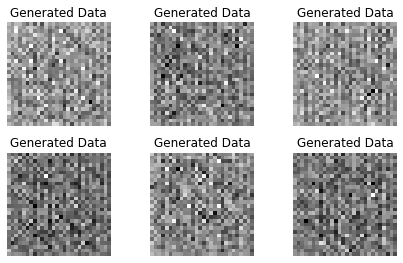

In [12]:
model.plot_imgs()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.7/dis

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type          | Params
----------------------------------------------
0 | generator   | Generator     | 361 K 
1 | discrimator | Discriminator | 21.4 K
----------------------------------------------
382 K     Trainable params
0         Non-trainable params
382 K     Total params
1.530     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch 0


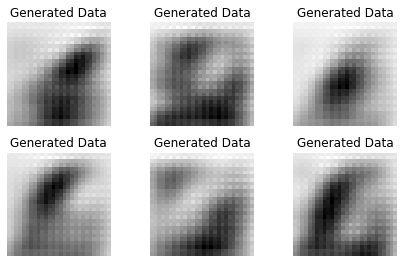

epoch 1


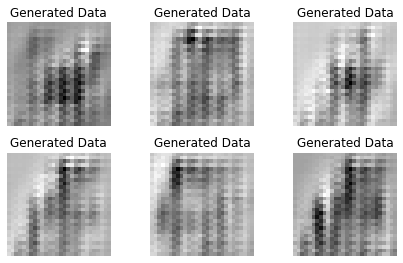

epoch 2


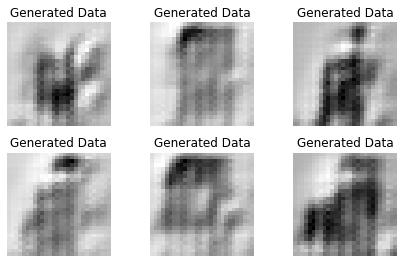

epoch 3


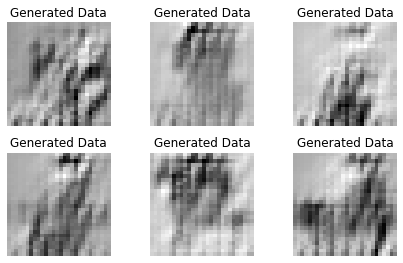

epoch 4


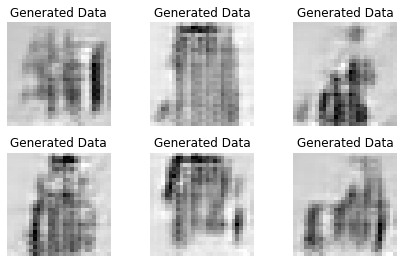

epoch 5


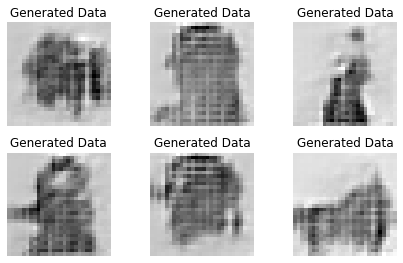

epoch 6


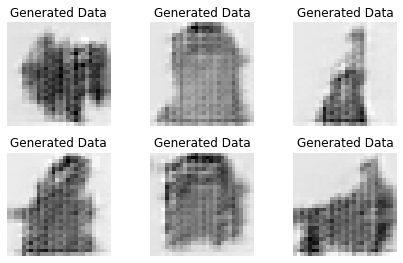

epoch 7


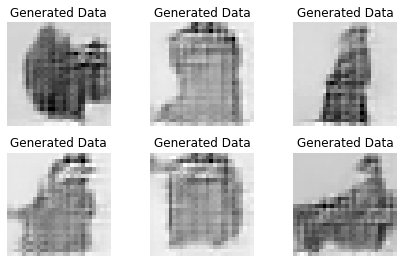

epoch 8


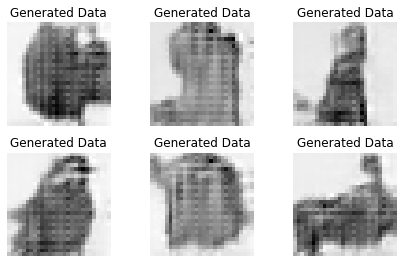

epoch 9


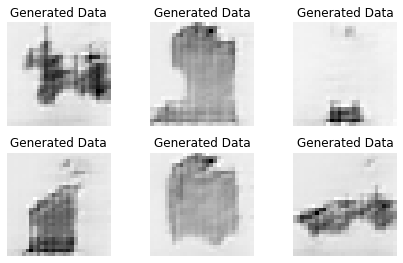

epoch 10


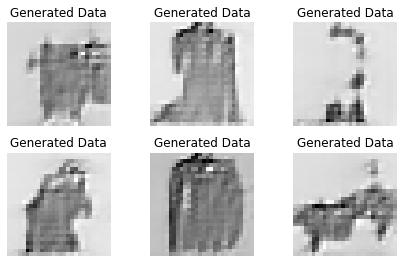

epoch 11


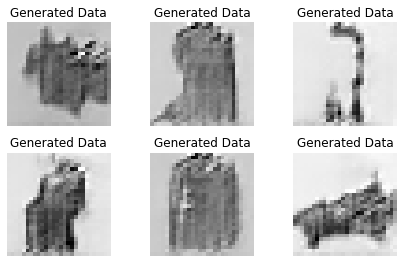

epoch 12


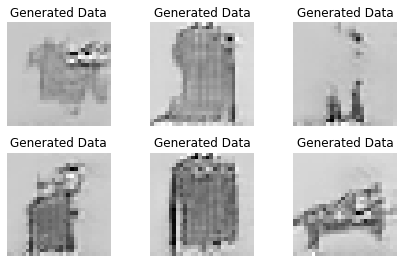

epoch 13


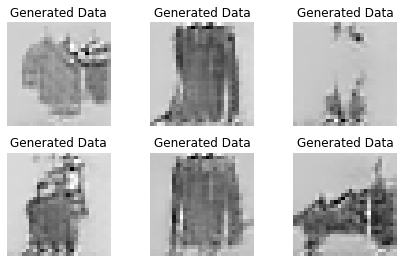

epoch 14


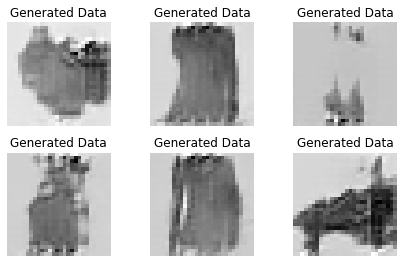

epoch 15


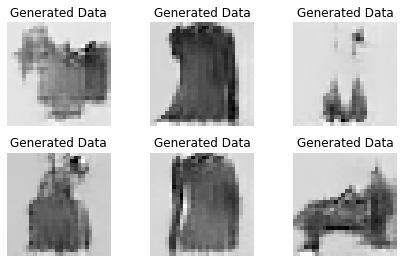

epoch 16


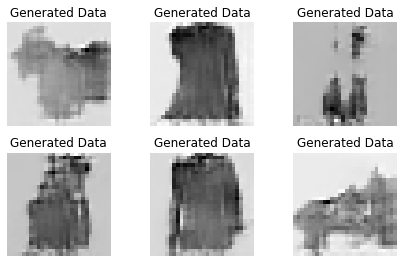

epoch 17


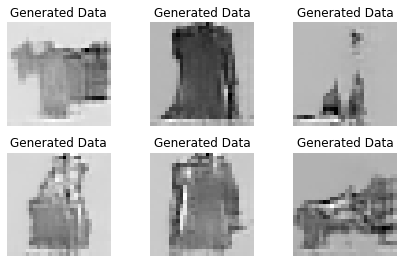

epoch 18


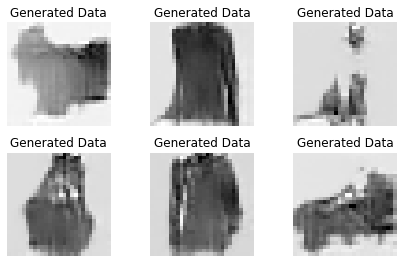

epoch 19


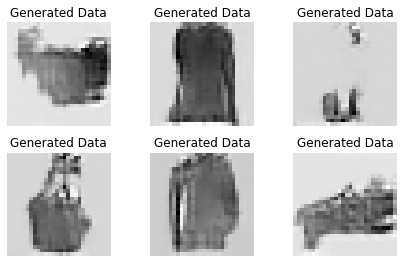

epoch 20


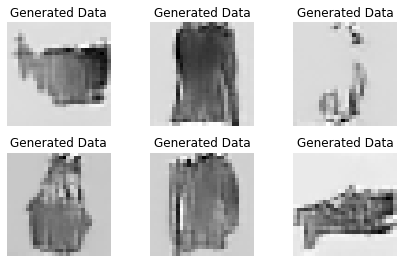

epoch 21


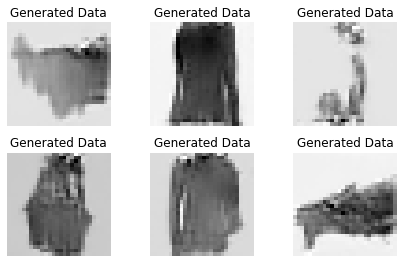

epoch 22


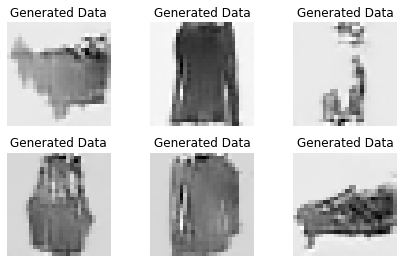

epoch 23


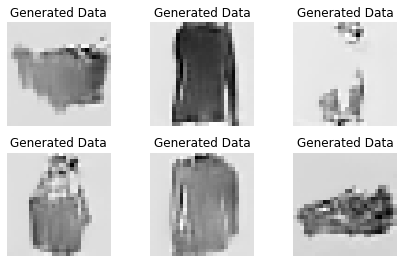

epoch 24


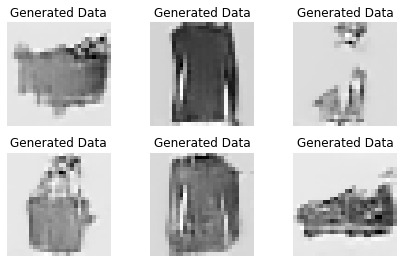

epoch 25


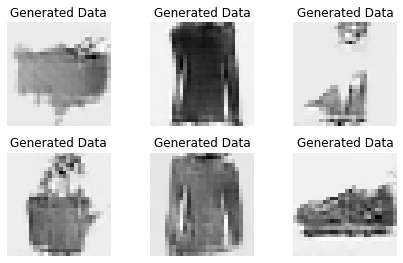

epoch 26


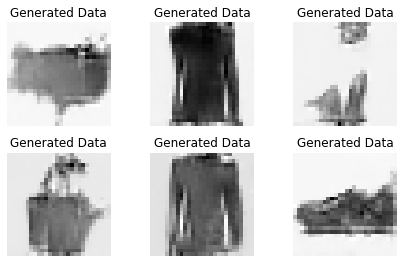

epoch 27


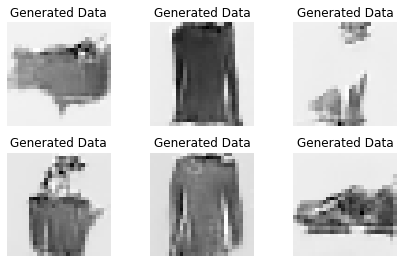

epoch 28


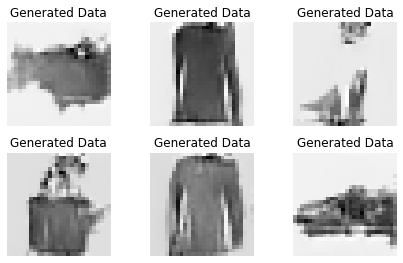

epoch 29


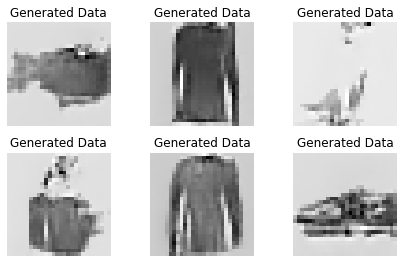

epoch 30


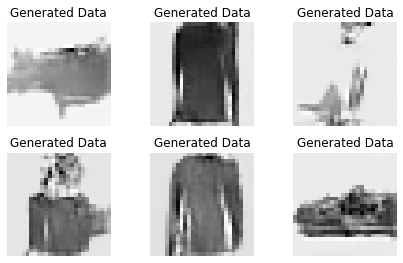

epoch 31


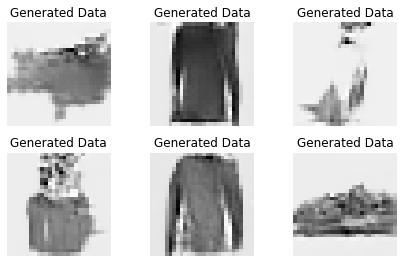

epoch 32


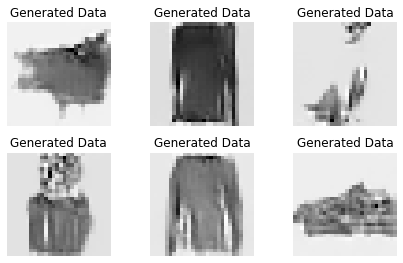

epoch 33


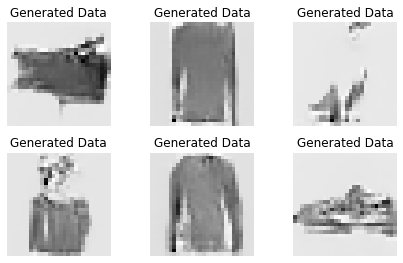

epoch 34


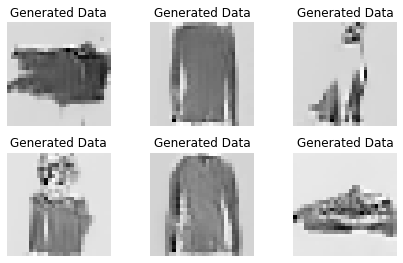

epoch 35


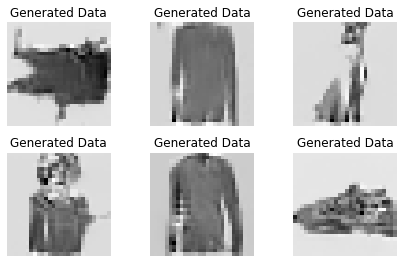

epoch 36


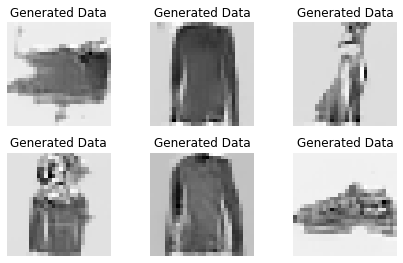

epoch 37


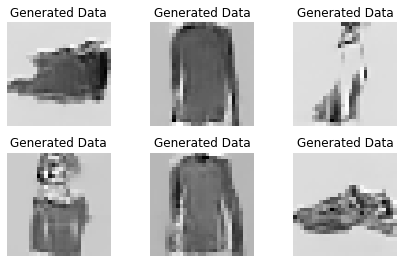

epoch 38


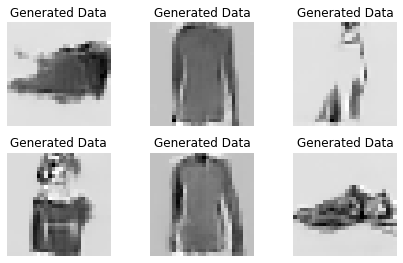

epoch 39


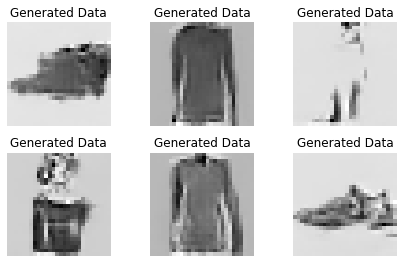

epoch 40


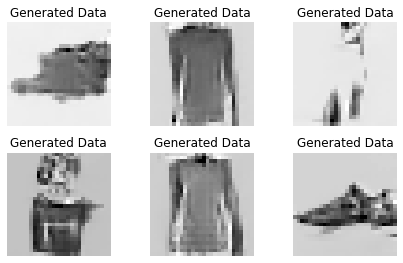

epoch 41


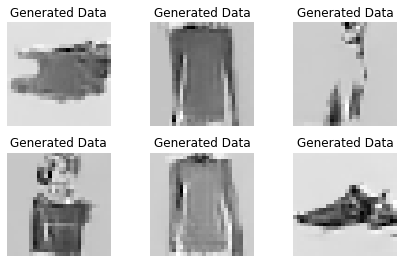

epoch 42


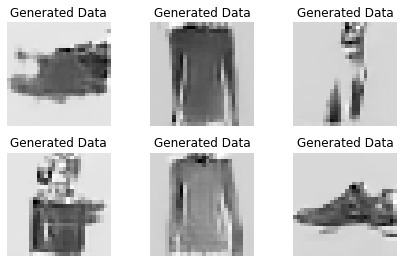

epoch 43


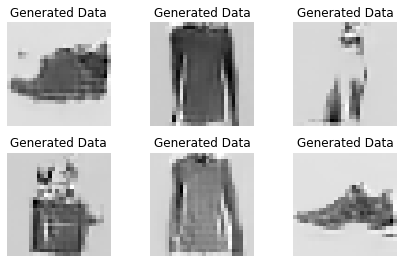

epoch 44


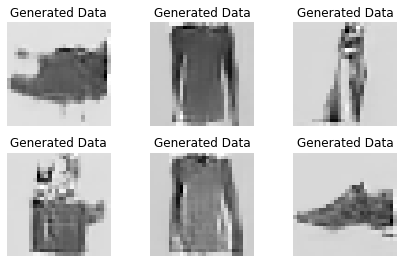

epoch 45


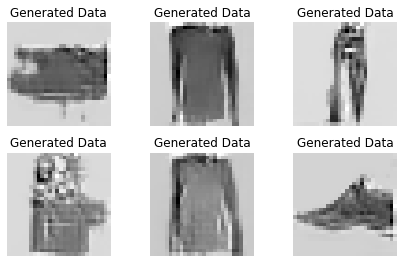

epoch 46


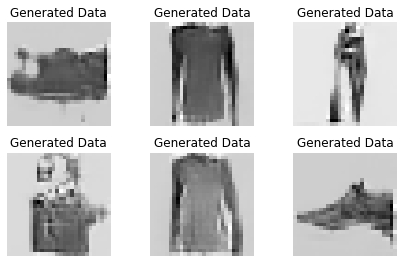

epoch 47


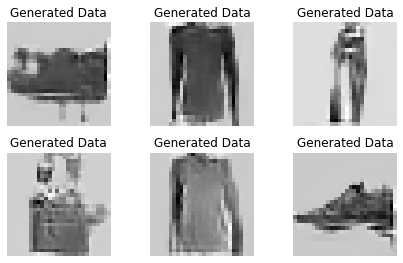

epoch 48


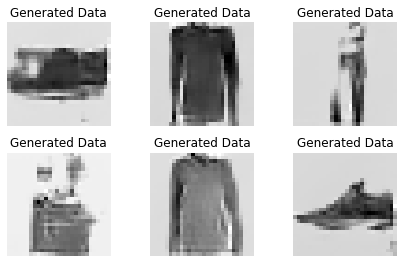

epoch 49


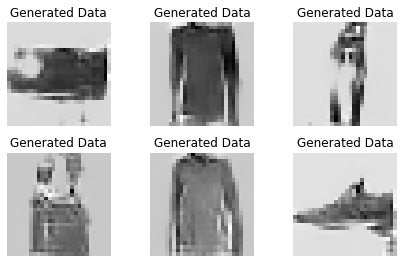

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [13]:
trainer = pl.Trainer(max_epochs=50, gpus=avail_gpu)
trainer.fit(model, datamodel)